In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread

import os
from os import listdir
import seaborn as sns 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.model_selection import train_test_split 

data = pd.read_csv('balanced_data.csv')
data.head() 

2024-11-09 08:56:50.409817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731142610.437220     513 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731142610.445261     513 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 08:56:50.483997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,patient_id,path,target
0,12626,./dataset/IDC_regular_ps50_idx5/12626/1/12626_...,1
1,10299,./dataset/IDC_regular_ps50_idx5/10299/0/10299_...,0
2,12949,./dataset/IDC_regular_ps50_idx5/12949/1/12949_...,1
3,14154,./dataset/IDC_regular_ps50_idx5/14154/0/14154_...,0
4,12810,./dataset/IDC_regular_ps50_idx5/12810/1/12810_...,1


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data['target'], random_state=40)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data['target'] = train_data['target'].astype(str)
test_data['target'] = test_data['target'].astype(str)

target_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=8,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=8,
    class_mode='binary'
)

Image batch shape: (8, 224, 224, 3)
Label batch shape: (8,)


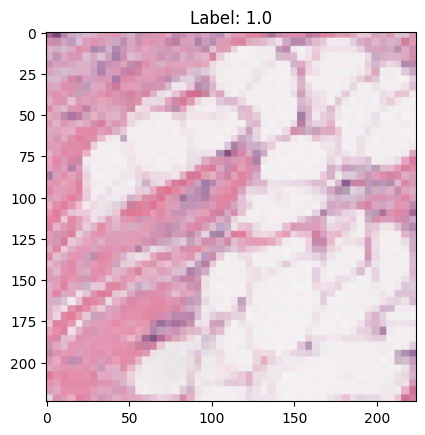

In [4]:
import matplotlib.pyplot as plt


images, labels = next(train_generator)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


plt.imshow(images[0])
plt.title(f"Label: {labels[0]}")
plt.show()



In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1731142641.101694     513 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [6]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/home/kavin/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1731142704.677979   60269 service.cc:148] XLA service 0x7fccd0002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731142704.678849   60269 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-09 08:58:26.687829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731142714.967189   60269 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-09 08:58:41.522101: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_confi

175/175 ━━━━━━━━━━━━━━━━━━━━ 132s 219ms/step - accuracy: 0.7561 - loss: 0.5223 - val_accuracy: 0.5000 - val_loss: 0.7012
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - accuracy: 0.8775 - loss: 0.3143 - val_accuracy: 0.5000 - val_loss: 0.7725
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.9147 - loss: 0.2025 - val_accuracy: 0.5000 - val_loss: 1.5144
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.9399 - loss: 0.1782 - val_accuracy: 0.5000 - val_loss: 1.1491
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9639 - loss: 0.0995 - val_accuracy: 0.5533 - val_loss: 1.6945
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9686 - loss: 0.1052 - val_accuracy: 0.7967 - val_loss: 0.5310
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9552 - loss: 0.1264 - val_accuracy: 0.7950 - val_loss: 0.8164
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.9765 - loss: 0.0767 - va

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8335 - loss: 0.5631
Test Loss: 0.5944281220436096
Test Accuracy: 0.8366666436195374


# Feature Extraction

In [8]:
from tensorflow.keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)

train_features = []
train_labels = []

num_batches = len(train_generator)

for i, (images, labels) in enumerate(train_generator):
    if i >= num_batches: 
        break
    
    print(f"Processing batch {i + 1}/{num_batches}...")  

    features = feature_extractor.predict_on_batch(images)  
    
    train_features.append(features)  
    train_labels.append(labels)      
    
    print(f"Batch {i + 1}/{num_batches} processed.")

print("Concatenating all features and labels...")
train_features = np.concatenate(train_features, axis=0) 
train_labels = np.concatenate(train_labels, axis=0)     

print("Feature extraction completed.")
print(f"Total train features shape: {train_features.shape}")  
print(f"Total train labels shape: {train_labels.shape}")     


Processing batch 1/175...
Batch 1/175 processed.
Processing batch 2/175...
Batch 2/175 processed.
Processing batch 3/175...
Batch 3/175 processed.
Processing batch 4/175...
Batch 4/175 processed.
Processing batch 5/175...
Batch 5/175 processed.
Processing batch 6/175...
Batch 6/175 processed.
Processing batch 7/175...
Batch 7/175 processed.
Processing batch 8/175...
Batch 8/175 processed.
Processing batch 9/175...
Batch 9/175 processed.
Processing batch 10/175...
Batch 10/175 processed.
Processing batch 11/175...
Batch 11/175 processed.
Processing batch 12/175...
Batch 12/175 processed.
Processing batch 13/175...
Batch 13/175 processed.
Processing batch 14/175...
Batch 14/175 processed.
Processing batch 15/175...
Batch 15/175 processed.
Processing batch 16/175...
Batch 16/175 processed.
Processing batch 17/175...
Batch 17/175 processed.
Processing batch 18/175...
Batch 18/175 processed.
Processing batch 19/175...
Batch 19/175 processed.
Processing batch 20/175...
Batch 20/175 processed

In [9]:
test_features = []
test_labels = []

num_batches = len(test_generator)

for i, (images, labels) in enumerate(test_generator):
    if i >= num_batches:  
        break
    
    print(f"Processing batch {i + 1}/{num_batches}...")  

    features = feature_extractor.predict_on_batch(images)  
    
    test_features.append(features) 
    test_labels.append(labels)     
    
    print(f"Batch {i + 1}/{num_batches} processed.")

print("Concatenating all features and labels...")
test_features = np.concatenate(test_features, axis=0) 
test_labels = np.concatenate(test_labels, axis=0)      

print("Feature extraction completed.")
print(f"Total test features shape: {test_features.shape}")  
print(f"Total test labels shape: {test_labels.shape}")     


Processing batch 1/75...
Batch 1/75 processed.
Processing batch 2/75...
Batch 2/75 processed.
Processing batch 3/75...
Batch 3/75 processed.
Processing batch 4/75...
Batch 4/75 processed.
Processing batch 5/75...
Batch 5/75 processed.
Processing batch 6/75...
Batch 6/75 processed.
Processing batch 7/75...
Batch 7/75 processed.
Processing batch 8/75...
Batch 8/75 processed.
Processing batch 9/75...
Batch 9/75 processed.
Processing batch 10/75...
Batch 10/75 processed.
Processing batch 11/75...
Batch 11/75 processed.
Processing batch 12/75...
Batch 12/75 processed.
Processing batch 13/75...
Batch 13/75 processed.
Processing batch 14/75...
Batch 14/75 processed.
Processing batch 15/75...
Batch 15/75 processed.
Processing batch 16/75...
Batch 16/75 processed.
Processing batch 17/75...
Batch 17/75 processed.
Processing batch 18/75...
Batch 18/75 processed.
Processing batch 19/75...
Batch 19/75 processed.
Processing batch 20/75...
Batch 20/75 processed.
Processing batch 21/75...
Batch 21/75 

In [10]:
np.set_printoptions(threshold=np.inf)  

for i, feature in enumerate(train_features[:1]):
    print(f"Sample {i + 1} Feature Vector (Length: {len(feature)}):")
    print(feature)
    print("\n")


Sample 1 Feature Vector (Length: 7):
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 2.01852059e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 5.29794884e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.95511091e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 